### Dataset Loading and testing

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
#currently installed theme will be used to
#set plot style if no arguments provided
jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]




#get the ranges of the loaded data
num_layers = X.shape[1]
num_lpoints = Y.shape[1]
size_max = np.amax(X)
size_min = np.amin(X)
size_av = 0.5*(size_max + size_min)

#this information is not given in the dataset
lam_min = 300
lam_max = 1200
lams = np.linspace(lam_min, lam_max, num_lpoints)

# X = np.expand_dims(X, 1)
# #X = np.expand_dims(X, 3)
# Y = np.expand_dims(Y, 1)
# #Y = np.expand_dims(Y, 3)






#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# normalize inputs 
x_train = (x_train - 50)/20 
x_test = (x_test - 50)/20 

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


Dataset has been loaded
x-train (60000, 8)
x-test  (40000, 8)
y-train (60000, 256)
y-test  (40000, 256)


#### Model Development

In [ ]:
from keras.utils import to_channels_first
x_train = to_channels_first(x_train)


In [2]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, UpSampling1D, Conv1D, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import PReLU


from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]



#define various models here
#naive percentage loss
def size_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_err = np.abs(y_true - y_pred)/y_true
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)


#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return np.mean(y_err)

#function to test performance on testset  
def calc_mre_K(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return K.mean(y_err)



def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(256, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'])
    return model

import timeit
#here we must have a function that calls the training routine n times and then gives avg and stddev 
# of the resulting figures
def net_performance(modelfunc, num_trials=3, batch_size=32, num_epochs=200, num_gpus=2):
    models = []
    train_err = np.ones(num_trials)
    test_err = np.ones(num_trials)
    val_err = np.ones(num_trials)
    train_time = np.ones(num_trials)
    for tnum in np.arange(num_trials):
        print("iteration: " + str(tnum + 1))
        model_curr = modelfunc()
        x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        start_time = timeit.default_timer()
        history = model_curr.fit(x_t, y_t,
                    batch_size=batch_size*num_gpus,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=(x_v, y_v))
        train_time[tnum] = timeit.default_timer() - start_time
        models.append(model_curr)
        train_err[tnum] =  (100.0/num_lpoints)*history.history['loss'][-1]/(batch_size*num_gpus)
        val_err[tnum] =   (100.0/num_lpoints)*history.history['val_loss'][-1]/(batch_size*num_gpus)
        test_err[tnum] = calc_mre(y_test, models[tnum].predict(x_test))
    return train_err, val_err, test_err, train_time

#staging area for new models 
def plot_training_history(history, factor):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(factor)
    val_loss = np.asarray(val_loss)/(factor)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,2.5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='Train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='Test error')
    axs.set_xlabel('Epoch number')
    #axs.set_ylim((0.4, 3))
    axs.set_xlim(left=1)
#     plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2]), 
#                ('0.1', '0.2', '0.3', '0.4', '0.5',  '0.75', '1.0', '1.5', '2'))
    plt.yticks(np.array([0.5, 0.75, 1.0, 1.5, 2]), 
               ('0.5',  '0.75', '1.0', '1.5', '2'))
    axs.set_ylabel('MRE (%)')
    axs.legend(loc="best")
    fig.savefig("foo2.pdf", bbox_inches='tight')

from keras.utils import to_channels_first

def conv1d_lkyrelu():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))  
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
 
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))


#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))  
    
    model.add(Flatten())
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    return model
    
    
def conv1d_model_bnorm():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first' ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    #model.add(UpSampling1D(size=5))

    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.3))
    
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
#     model.add(Dropout(0.3))

#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))    
    
    
    
    model.add(Flatten())
    # Compile model
#     if num_gpus == 1:
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#     else:
#         model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'], context = gpu_list)
    
    
    return model    

def resnetb():
    model = Sequential()
    
    #first layer6
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    model.add(Reshape((8, 32)))
    
    
    #resnet block
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
    
    
    
    #Last layer
    model.add(Flatten())
    
    #compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    
    return model


Using MXNet backend


### Model testing

In [4]:
%autoreload
# import warnings
# warnings.filterwarnings('ignore')


# model = resnetb()
# #model = conv1d_lkyrelu()
# #model = conv1d_model_bnorm()
# #model = conv1d_model(1)

# #model = naiveploss_model()
# model.summary()

    
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# #SVG(model_to_dot(model).create(prog='dot', format='svg'))
 


    
    
import scnets as scn

# model = scn.resnet(in_size=8,     
#                    out_size=256,
#                    num_units=3,
#                    red_dim=16,
#                    batch_size=64,
#                    ker_size=3)

# model = scn.conv1dmodel(in_size=8, 
#         out_size=256,
#         batch_size=64,
#         c1_nf=64,
#         clayers=4,
#         ker_size=5)

model = scn.convprel(in_size=8, 
        out_size=256,
        batch_size=64,
        c1_nf=64,
        clayers=4,
        ker_size=3)

# model = scn.fullycon(in_size=8, 
#                      out_size=256, 
#                      batch_size=64,
#                      N_hidden=2, 
#                      N_neurons=256, 
#                      N_gpus=1)





# # from keras import optimizers
# # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# #model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K])

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils.vis_utils import plot_model

# SVG(model_to_dot(model, show_shapes=False, show_layer_names=False).create(prog='dot', format='svg'))


# #plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model_resnet.svg')



model.summary()    
    
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_t, y_t,
                    batch_size=64,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_v, y_v))





# y_pred = model.predict(x_test)
# print(calc_mre(y_test, y_pred))



/home/hegder/anaconda3/lib/python3.7/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/lib/python3.7/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.t

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 256)               2304      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 256)               256       
_________________________________________________________________
Reshape1 (Reshape)           (None, 4, 64)             0         
_________________________________________________________________
Up1 (UpSampling1D)           (None, 8, 64)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 8, 64)             12352     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 8, 64)             512       
_________________________________________________________________
Conv2 (Conv1D)               (None, 8, 32)             6176      
__________

/home/hegder/anaconda3/lib/python3.7/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 4s 77us/step - loss: 1902.7889 - calc_mre_K: 11.6137 - val_loss: 775.0015 - val_calc_mre_K: 4.7364
Epoch 2/2000
48000/48000 [==============================] - 2s 50us/step - loss: 636.6252 - calc_mre_K: 3.8857 - val_loss: 520.5962 - val_calc_mre_K: 3.1815
Epoch 3/2000
48000/48000 [==============================] - 2s 50us/step - loss: 498.0257 - calc_mre_K: 3.0397 - val_loss: 450.9856 - val_calc_mre_K: 2.7561
Epoch 4/2000
48000/48000 [==============================] - 2s 50us/step - loss: 444.5925 - calc_mre_K: 2.7136 - val_loss: 440.9772 - val_calc_mre_K: 2.6950
Epoch 5/2000
48000/48000 [==============================] - 2s 50us/step - loss: 415.3938 - calc_mre_K: 2.5354 - val_loss: 428.2262 - val_calc_mre_K: 2.6171
Epoch 6/2000
48000/48000 [==============================] - 2s 51us/step - loss: 408.2033 - calc_mre_K: 2.4915 - val_loss: 371.1729 - val_calc_mre_K: 2.2685
Epoch 7/2000
48000/48000 [==============================] - 2s 50us/s

Epoch 53/2000
48000/48000 [==============================] - 2s 52us/step - loss: 173.1484 - calc_mre_K: 1.0568 - val_loss: 157.6922 - val_calc_mre_K: 0.9638
Epoch 54/2000
48000/48000 [==============================] - 2s 52us/step - loss: 163.4685 - calc_mre_K: 0.9977 - val_loss: 152.8588 - val_calc_mre_K: 0.9343
Epoch 55/2000
48000/48000 [==============================] - 2s 52us/step - loss: 171.4014 - calc_mre_K: 1.0462 - val_loss: 177.3427 - val_calc_mre_K: 1.0839
Epoch 56/2000
48000/48000 [==============================] - 2s 52us/step - loss: 180.4526 - calc_mre_K: 1.1014 - val_loss: 150.5242 - val_calc_mre_K: 0.9200
Epoch 57/2000
48000/48000 [==============================] - 2s 50us/step - loss: 161.5351 - calc_mre_K: 0.9859 - val_loss: 157.3193 - val_calc_mre_K: 0.9615
Epoch 58/2000
48000/48000 [==============================] - 2s 51us/step - loss: 167.1473 - calc_mre_K: 1.0202 - val_loss: 148.9960 - val_calc_mre_K: 0.9106
Epoch 59/2000
48000/48000 [=========================

Epoch 105/2000
48000/48000 [==============================] - 2s 52us/step - loss: 124.2600 - calc_mre_K: 0.7584 - val_loss: 129.8107 - val_calc_mre_K: 0.7934
Epoch 106/2000
48000/48000 [==============================] - 2s 52us/step - loss: 125.3140 - calc_mre_K: 0.7649 - val_loss: 122.2460 - val_calc_mre_K: 0.7472
Epoch 107/2000
48000/48000 [==============================] - 2s 51us/step - loss: 126.5669 - calc_mre_K: 0.7725 - val_loss: 132.0504 - val_calc_mre_K: 0.8071
Epoch 108/2000
48000/48000 [==============================] - 3s 53us/step - loss: 125.6400 - calc_mre_K: 0.7668 - val_loss: 130.3404 - val_calc_mre_K: 0.7967
Epoch 109/2000
48000/48000 [==============================] - 2s 48us/step - loss: 126.6342 - calc_mre_K: 0.7729 - val_loss: 131.8918 - val_calc_mre_K: 0.8061
Epoch 110/2000
48000/48000 [==============================] - 3s 52us/step - loss: 122.4863 - calc_mre_K: 0.7476 - val_loss: 120.7282 - val_calc_mre_K: 0.7379
Epoch 111/2000
48000/48000 [==================

48000/48000 [==============================] - 3s 53us/step - loss: 108.5068 - calc_mre_K: 0.6623 - val_loss: 112.1881 - val_calc_mre_K: 0.6857
Epoch 157/2000
48000/48000 [==============================] - 2s 52us/step - loss: 109.4276 - calc_mre_K: 0.6679 - val_loss: 108.4361 - val_calc_mre_K: 0.6627
Epoch 158/2000
48000/48000 [==============================] - 2s 52us/step - loss: 110.0511 - calc_mre_K: 0.6717 - val_loss: 108.6786 - val_calc_mre_K: 0.6642
Epoch 159/2000
48000/48000 [==============================] - 2s 52us/step - loss: 109.6806 - calc_mre_K: 0.6694 - val_loss: 126.1993 - val_calc_mre_K: 0.7713
Epoch 160/2000
48000/48000 [==============================] - 3s 54us/step - loss: 108.2778 - calc_mre_K: 0.6609 - val_loss: 107.8562 - val_calc_mre_K: 0.6592
Epoch 161/2000
48000/48000 [==============================] - 2s 52us/step - loss: 111.2709 - calc_mre_K: 0.6791 - val_loss: 104.5160 - val_calc_mre_K: 0.6388
Epoch 162/2000
48000/48000 [==============================] -

48000/48000 [==============================] - 2s 51us/step - loss: 103.7325 - calc_mre_K: 0.6331 - val_loss: 96.6600 - val_calc_mre_K: 0.5908
Epoch 208/2000
48000/48000 [==============================] - 3s 52us/step - loss: 106.8788 - calc_mre_K: 0.6523 - val_loss: 121.7051 - val_calc_mre_K: 0.7439
Epoch 209/2000
48000/48000 [==============================] - 3s 54us/step - loss: 103.1602 - calc_mre_K: 0.6296 - val_loss: 107.8801 - val_calc_mre_K: 0.6593
Epoch 210/2000
48000/48000 [==============================] - 3s 54us/step - loss: 100.1636 - calc_mre_K: 0.6114 - val_loss: 97.2253 - val_calc_mre_K: 0.5942
Epoch 211/2000
48000/48000 [==============================] - 3s 52us/step - loss: 100.6832 - calc_mre_K: 0.6145 - val_loss: 109.2051 - val_calc_mre_K: 0.6674
Epoch 212/2000
48000/48000 [==============================] - 2s 51us/step - loss: 102.0518 - calc_mre_K: 0.6229 - val_loss: 97.3057 - val_calc_mre_K: 0.5947
Epoch 213/2000
48000/48000 [==============================] - 2s

48000/48000 [==============================] - 2s 49us/step - loss: 96.2652 - calc_mre_K: 0.5876 - val_loss: 99.1111 - val_calc_mre_K: 0.6058
Epoch 260/2000
48000/48000 [==============================] - 3s 52us/step - loss: 96.5169 - calc_mre_K: 0.5891 - val_loss: 90.8914 - val_calc_mre_K: 0.5555
Epoch 261/2000
48000/48000 [==============================] - 3s 52us/step - loss: 96.0186 - calc_mre_K: 0.5861 - val_loss: 104.5424 - val_calc_mre_K: 0.6389
Epoch 262/2000
48000/48000 [==============================] - 2s 52us/step - loss: 99.4370 - calc_mre_K: 0.6069 - val_loss: 92.0787 - val_calc_mre_K: 0.5628
Epoch 263/2000
48000/48000 [==============================] - 2s 50us/step - loss: 95.1902 - calc_mre_K: 0.5810 - val_loss: 105.8537 - val_calc_mre_K: 0.6470
Epoch 264/2000
48000/48000 [==============================] - 2s 51us/step - loss: 96.1991 - calc_mre_K: 0.5872 - val_loss: 90.6992 - val_calc_mre_K: 0.5543
Epoch 265/2000
48000/48000 [==============================] - 2s 51us/s

48000/48000 [==============================] - 2s 51us/step - loss: 92.7290 - calc_mre_K: 0.5660 - val_loss: 96.9130 - val_calc_mre_K: 0.5923
Epoch 312/2000
48000/48000 [==============================] - 2s 51us/step - loss: 91.2675 - calc_mre_K: 0.5571 - val_loss: 88.3411 - val_calc_mre_K: 0.5399
Epoch 313/2000
48000/48000 [==============================] - 2s 52us/step - loss: 94.3594 - calc_mre_K: 0.5759 - val_loss: 86.7671 - val_calc_mre_K: 0.5303
Epoch 314/2000
48000/48000 [==============================] - 2s 51us/step - loss: 90.7405 - calc_mre_K: 0.5538 - val_loss: 90.2045 - val_calc_mre_K: 0.5513
Epoch 315/2000
48000/48000 [==============================] - 2s 52us/step - loss: 91.6234 - calc_mre_K: 0.5592 - val_loss: 104.7195 - val_calc_mre_K: 0.6400
Epoch 316/2000
48000/48000 [==============================] - 2s 51us/step - loss: 91.6651 - calc_mre_K: 0.5595 - val_loss: 90.1575 - val_calc_mre_K: 0.5510
Epoch 317/2000
48000/48000 [==============================] - 2s 51us/st

48000/48000 [==============================] - 3s 53us/step - loss: 88.4310 - calc_mre_K: 0.5397 - val_loss: 91.2048 - val_calc_mre_K: 0.5574
Epoch 364/2000
48000/48000 [==============================] - 3s 53us/step - loss: 87.4593 - calc_mre_K: 0.5338 - val_loss: 84.1885 - val_calc_mre_K: 0.5145
Epoch 365/2000
48000/48000 [==============================] - 3s 52us/step - loss: 87.9491 - calc_mre_K: 0.5368 - val_loss: 88.9228 - val_calc_mre_K: 0.5435
Epoch 366/2000
48000/48000 [==============================] - 3s 53us/step - loss: 88.7196 - calc_mre_K: 0.5415 - val_loss: 87.1904 - val_calc_mre_K: 0.5329
Epoch 367/2000
48000/48000 [==============================] - 2s 51us/step - loss: 87.0804 - calc_mre_K: 0.5315 - val_loss: 92.9627 - val_calc_mre_K: 0.5682
Epoch 368/2000
48000/48000 [==============================] - 3s 53us/step - loss: 88.3304 - calc_mre_K: 0.5391 - val_loss: 85.2570 - val_calc_mre_K: 0.5211
Epoch 369/2000
48000/48000 [==============================] - 3s 53us/ste

48000/48000 [==============================] - 2s 51us/step - loss: 85.7862 - calc_mre_K: 0.5236 - val_loss: 85.3674 - val_calc_mre_K: 0.5217
Epoch 416/2000
48000/48000 [==============================] - 2s 51us/step - loss: 84.7693 - calc_mre_K: 0.5174 - val_loss: 87.4442 - val_calc_mre_K: 0.5344
Epoch 417/2000
48000/48000 [==============================] - 2s 51us/step - loss: 85.3169 - calc_mre_K: 0.5207 - val_loss: 86.1009 - val_calc_mre_K: 0.5262
Epoch 418/2000
48000/48000 [==============================] - 2s 49us/step - loss: 85.3710 - calc_mre_K: 0.5211 - val_loss: 85.1696 - val_calc_mre_K: 0.5205
Epoch 419/2000
48000/48000 [==============================] - 3s 53us/step - loss: 85.3657 - calc_mre_K: 0.5210 - val_loss: 87.4651 - val_calc_mre_K: 0.5346
Epoch 420/2000
48000/48000 [==============================] - 3s 52us/step - loss: 85.5295 - calc_mre_K: 0.5220 - val_loss: 83.0808 - val_calc_mre_K: 0.5078
Epoch 421/2000
48000/48000 [==============================] - 3s 52us/ste

48000/48000 [==============================] - 2s 51us/step - loss: 83.5453 - calc_mre_K: 0.5099 - val_loss: 80.4774 - val_calc_mre_K: 0.4918
Epoch 468/2000
48000/48000 [==============================] - 2s 52us/step - loss: 83.4901 - calc_mre_K: 0.5096 - val_loss: 79.9028 - val_calc_mre_K: 0.4883
Epoch 469/2000
48000/48000 [==============================] - 2s 52us/step - loss: 83.2311 - calc_mre_K: 0.5080 - val_loss: 81.5334 - val_calc_mre_K: 0.4983
Epoch 470/2000
48000/48000 [==============================] - 2s 51us/step - loss: 83.9753 - calc_mre_K: 0.5125 - val_loss: 81.3385 - val_calc_mre_K: 0.4971
Epoch 471/2000
48000/48000 [==============================] - 2s 51us/step - loss: 82.7272 - calc_mre_K: 0.5049 - val_loss: 84.2941 - val_calc_mre_K: 0.5152
Epoch 472/2000
48000/48000 [==============================] - 3s 52us/step - loss: 84.1182 - calc_mre_K: 0.5134 - val_loss: 83.8071 - val_calc_mre_K: 0.5122
Epoch 473/2000
48000/48000 [==============================] - 3s 52us/ste

48000/48000 [==============================] - 3s 53us/step - loss: 81.9307 - calc_mre_K: 0.5001 - val_loss: 77.4843 - val_calc_mre_K: 0.4736
Epoch 520/2000
48000/48000 [==============================] - 3s 54us/step - loss: 82.6650 - calc_mre_K: 0.5045 - val_loss: 80.0393 - val_calc_mre_K: 0.4892
Epoch 521/2000
48000/48000 [==============================] - 3s 53us/step - loss: 80.1645 - calc_mre_K: 0.4893 - val_loss: 79.4120 - val_calc_mre_K: 0.4853
Epoch 522/2000
48000/48000 [==============================] - 2s 52us/step - loss: 81.4566 - calc_mre_K: 0.4972 - val_loss: 81.4097 - val_calc_mre_K: 0.4975
Epoch 523/2000
48000/48000 [==============================] - 2s 52us/step - loss: 80.9915 - calc_mre_K: 0.4943 - val_loss: 78.4441 - val_calc_mre_K: 0.4794
Epoch 524/2000
48000/48000 [==============================] - 2s 51us/step - loss: 81.9312 - calc_mre_K: 0.5001 - val_loss: 77.2055 - val_calc_mre_K: 0.4719
Epoch 525/2000
48000/48000 [==============================] - 2s 52us/ste

48000/48000 [==============================] - 2s 52us/step - loss: 79.1038 - calc_mre_K: 0.4828 - val_loss: 77.3020 - val_calc_mre_K: 0.4724
Epoch 572/2000
48000/48000 [==============================] - 2s 51us/step - loss: 78.5288 - calc_mre_K: 0.4793 - val_loss: 80.5382 - val_calc_mre_K: 0.4922
Epoch 573/2000
48000/48000 [==============================] - 2s 51us/step - loss: 79.0160 - calc_mre_K: 0.4823 - val_loss: 77.1178 - val_calc_mre_K: 0.4713
Epoch 574/2000
48000/48000 [==============================] - 3s 52us/step - loss: 77.7734 - calc_mre_K: 0.4747 - val_loss: 78.0108 - val_calc_mre_K: 0.4768
Epoch 575/2000
48000/48000 [==============================] - 2s 50us/step - loss: 79.0328 - calc_mre_K: 0.4824 - val_loss: 99.5002 - val_calc_mre_K: 0.6081
Epoch 576/2000
48000/48000 [==============================] - 2s 51us/step - loss: 79.1704 - calc_mre_K: 0.4832 - val_loss: 81.2237 - val_calc_mre_K: 0.4964
Epoch 577/2000
48000/48000 [==============================] - 2s 52us/ste

48000/48000 [==============================] - 2s 50us/step - loss: 77.7628 - calc_mre_K: 0.4746 - val_loss: 76.4259 - val_calc_mre_K: 0.4671
Epoch 624/2000
48000/48000 [==============================] - 3s 53us/step - loss: 76.4415 - calc_mre_K: 0.4666 - val_loss: 77.8054 - val_calc_mre_K: 0.4755
Epoch 625/2000
48000/48000 [==============================] - 3s 53us/step - loss: 76.7878 - calc_mre_K: 0.4687 - val_loss: 75.8927 - val_calc_mre_K: 0.4638
Epoch 626/2000
48000/48000 [==============================] - 3s 52us/step - loss: 77.4494 - calc_mre_K: 0.4727 - val_loss: 75.8223 - val_calc_mre_K: 0.4634
Epoch 627/2000
48000/48000 [==============================] - 3s 53us/step - loss: 77.9056 - calc_mre_K: 0.4755 - val_loss: 79.2699 - val_calc_mre_K: 0.4845
Epoch 628/2000
48000/48000 [==============================] - 2s 51us/step - loss: 77.4744 - calc_mre_K: 0.4729 - val_loss: 82.6949 - val_calc_mre_K: 0.5054
Epoch 629/2000
48000/48000 [==============================] - 3s 53us/ste

48000/48000 [==============================] - 3s 52us/step - loss: 76.2967 - calc_mre_K: 0.4657 - val_loss: 73.3028 - val_calc_mre_K: 0.4480
Epoch 676/2000
48000/48000 [==============================] - 2s 52us/step - loss: 76.3319 - calc_mre_K: 0.4659 - val_loss: 75.1129 - val_calc_mre_K: 0.4590
Epoch 677/2000
48000/48000 [==============================] - 3s 53us/step - loss: 76.0374 - calc_mre_K: 0.4641 - val_loss: 77.5969 - val_calc_mre_K: 0.4742
Epoch 678/2000
48000/48000 [==============================] - 2s 51us/step - loss: 76.7287 - calc_mre_K: 0.4683 - val_loss: 74.6554 - val_calc_mre_K: 0.4563
Epoch 679/2000
48000/48000 [==============================] - 3s 52us/step - loss: 76.0910 - calc_mre_K: 0.4644 - val_loss: 73.9943 - val_calc_mre_K: 0.4522
Epoch 680/2000
48000/48000 [==============================] - 3s 53us/step - loss: 75.8340 - calc_mre_K: 0.4629 - val_loss: 93.0210 - val_calc_mre_K: 0.5685
Epoch 681/2000
48000/48000 [==============================] - 3s 53us/ste

48000/48000 [==============================] - 2s 52us/step - loss: 75.4082 - calc_mre_K: 0.4603 - val_loss: 73.3399 - val_calc_mre_K: 0.4482
Epoch 728/2000
48000/48000 [==============================] - 3s 53us/step - loss: 74.8492 - calc_mre_K: 0.4568 - val_loss: 76.1310 - val_calc_mre_K: 0.4653
Epoch 729/2000
48000/48000 [==============================] - 3s 52us/step - loss: 75.2312 - calc_mre_K: 0.4592 - val_loss: 72.0959 - val_calc_mre_K: 0.4406
Epoch 730/2000
48000/48000 [==============================] - 3s 53us/step - loss: 75.8252 - calc_mre_K: 0.4628 - val_loss: 72.6540 - val_calc_mre_K: 0.4440
Epoch 731/2000
48000/48000 [==============================] - 3s 53us/step - loss: 74.9913 - calc_mre_K: 0.4577 - val_loss: 73.9318 - val_calc_mre_K: 0.4518
Epoch 732/2000
48000/48000 [==============================] - 3s 53us/step - loss: 75.3091 - calc_mre_K: 0.4597 - val_loss: 77.6359 - val_calc_mre_K: 0.4745
Epoch 733/2000
48000/48000 [==============================] - 3s 54us/ste

48000/48000 [==============================] - 3s 52us/step - loss: 73.7800 - calc_mre_K: 0.4503 - val_loss: 83.0831 - val_calc_mre_K: 0.5078
Epoch 780/2000
48000/48000 [==============================] - 2s 51us/step - loss: 74.6032 - calc_mre_K: 0.4553 - val_loss: 73.0489 - val_calc_mre_K: 0.4465
Epoch 781/2000
48000/48000 [==============================] - 3s 53us/step - loss: 74.0856 - calc_mre_K: 0.4522 - val_loss: 77.1541 - val_calc_mre_K: 0.4715
Epoch 782/2000
48000/48000 [==============================] - 2s 52us/step - loss: 74.2647 - calc_mre_K: 0.4533 - val_loss: 72.9310 - val_calc_mre_K: 0.4457
Epoch 783/2000
48000/48000 [==============================] - 2s 51us/step - loss: 74.5035 - calc_mre_K: 0.4547 - val_loss: 75.0990 - val_calc_mre_K: 0.4590
Epoch 784/2000
48000/48000 [==============================] - 3s 53us/step - loss: 74.5927 - calc_mre_K: 0.4553 - val_loss: 71.8580 - val_calc_mre_K: 0.4392
Epoch 785/2000
48000/48000 [==============================] - 3s 52us/ste

48000/48000 [==============================] - 2s 50us/step - loss: 73.0431 - calc_mre_K: 0.4458 - val_loss: 73.4316 - val_calc_mre_K: 0.4488
Epoch 832/2000
48000/48000 [==============================] - 2s 50us/step - loss: 73.0619 - calc_mre_K: 0.4459 - val_loss: 83.7474 - val_calc_mre_K: 0.5118
Epoch 833/2000
48000/48000 [==============================] - 2s 50us/step - loss: 74.0158 - calc_mre_K: 0.4518 - val_loss: 80.3359 - val_calc_mre_K: 0.4910
Epoch 834/2000
48000/48000 [==============================] - 2s 51us/step - loss: 74.5575 - calc_mre_K: 0.4551 - val_loss: 70.4314 - val_calc_mre_K: 0.4305
Epoch 835/2000
48000/48000 [==============================] - 2s 50us/step - loss: 72.8543 - calc_mre_K: 0.4447 - val_loss: 77.6904 - val_calc_mre_K: 0.4748
Epoch 836/2000
48000/48000 [==============================] - 2s 50us/step - loss: 73.0979 - calc_mre_K: 0.4462 - val_loss: 75.1460 - val_calc_mre_K: 0.4593
Epoch 837/2000
48000/48000 [==============================] - 2s 51us/ste

48000/48000 [==============================] - 3s 53us/step - loss: 72.6625 - calc_mre_K: 0.4435 - val_loss: 72.5712 - val_calc_mre_K: 0.4435
Epoch 884/2000
48000/48000 [==============================] - 3s 53us/step - loss: 73.0796 - calc_mre_K: 0.4460 - val_loss: 74.1943 - val_calc_mre_K: 0.4534
Epoch 885/2000
48000/48000 [==============================] - 3s 53us/step - loss: 72.8259 - calc_mre_K: 0.4445 - val_loss: 72.5252 - val_calc_mre_K: 0.4432
Epoch 886/2000
48000/48000 [==============================] - 3s 53us/step - loss: 72.2531 - calc_mre_K: 0.4410 - val_loss: 76.3423 - val_calc_mre_K: 0.4666
Epoch 887/2000
48000/48000 [==============================] - 3s 53us/step - loss: 72.4299 - calc_mre_K: 0.4421 - val_loss: 73.4423 - val_calc_mre_K: 0.4488
Epoch 888/2000
48000/48000 [==============================] - 3s 52us/step - loss: 72.5955 - calc_mre_K: 0.4431 - val_loss: 71.3515 - val_calc_mre_K: 0.4361
Epoch 889/2000
48000/48000 [==============================] - 3s 53us/ste

48000/48000 [==============================] - 3s 52us/step - loss: 71.8713 - calc_mre_K: 0.4387 - val_loss: 72.3075 - val_calc_mre_K: 0.4419
Epoch 936/2000
48000/48000 [==============================] - 2s 52us/step - loss: 71.5063 - calc_mre_K: 0.4364 - val_loss: 71.1165 - val_calc_mre_K: 0.4346
Epoch 937/2000
48000/48000 [==============================] - 3s 52us/step - loss: 72.0541 - calc_mre_K: 0.4398 - val_loss: 72.7008 - val_calc_mre_K: 0.4443
Epoch 938/2000
48000/48000 [==============================] - 3s 53us/step - loss: 71.6675 - calc_mre_K: 0.4374 - val_loss: 71.4258 - val_calc_mre_K: 0.4365
Epoch 939/2000
48000/48000 [==============================] - 3s 52us/step - loss: 71.4339 - calc_mre_K: 0.4360 - val_loss: 74.9233 - val_calc_mre_K: 0.4579
Epoch 940/2000
48000/48000 [==============================] - 3s 53us/step - loss: 72.4590 - calc_mre_K: 0.4423 - val_loss: 74.1253 - val_calc_mre_K: 0.4530
Epoch 941/2000
48000/48000 [==============================] - 3s 53us/ste

48000/48000 [==============================] - 3s 52us/step - loss: 70.7230 - calc_mre_K: 0.4317 - val_loss: 70.2102 - val_calc_mre_K: 0.4291
Epoch 988/2000
48000/48000 [==============================] - 2s 51us/step - loss: 70.5966 - calc_mre_K: 0.4309 - val_loss: 70.5693 - val_calc_mre_K: 0.4313
Epoch 989/2000
48000/48000 [==============================] - 2s 51us/step - loss: 71.3090 - calc_mre_K: 0.4352 - val_loss: 67.6903 - val_calc_mre_K: 0.4137
Epoch 990/2000
48000/48000 [==============================] - 2s 52us/step - loss: 71.0700 - calc_mre_K: 0.4338 - val_loss: 69.7356 - val_calc_mre_K: 0.4262
Epoch 991/2000
48000/48000 [==============================] - 3s 53us/step - loss: 70.2682 - calc_mre_K: 0.4289 - val_loss: 68.1112 - val_calc_mre_K: 0.4163
Epoch 992/2000
48000/48000 [==============================] - 3s 53us/step - loss: 71.3900 - calc_mre_K: 0.4357 - val_loss: 69.5300 - val_calc_mre_K: 0.4249
Epoch 993/2000
48000/48000 [==============================] - 2s 50us/ste

48000/48000 [==============================] - 2s 52us/step - loss: 69.8232 - calc_mre_K: 0.4262 - val_loss: 68.9723 - val_calc_mre_K: 0.4215
Epoch 1040/2000
48000/48000 [==============================] - 2s 51us/step - loss: 70.5563 - calc_mre_K: 0.4306 - val_loss: 71.2723 - val_calc_mre_K: 0.4356
Epoch 1041/2000
48000/48000 [==============================] - 3s 53us/step - loss: 69.5393 - calc_mre_K: 0.4244 - val_loss: 69.3127 - val_calc_mre_K: 0.4236
Epoch 1042/2000
48000/48000 [==============================] - 3s 53us/step - loss: 70.4038 - calc_mre_K: 0.4297 - val_loss: 73.4934 - val_calc_mre_K: 0.4492
Epoch 1043/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.9778 - calc_mre_K: 0.4271 - val_loss: 73.0066 - val_calc_mre_K: 0.4462
Epoch 1044/2000
48000/48000 [==============================] - 3s 53us/step - loss: 70.3670 - calc_mre_K: 0.4295 - val_loss: 69.4487 - val_calc_mre_K: 0.4244
Epoch 1045/2000
48000/48000 [==============================] - 3s 53

Epoch 1091/2000
48000/48000 [==============================] - 2s 52us/step - loss: 70.1700 - calc_mre_K: 0.4283 - val_loss: 69.9686 - val_calc_mre_K: 0.4276
Epoch 1092/2000
48000/48000 [==============================] - 2s 51us/step - loss: 70.1071 - calc_mre_K: 0.4279 - val_loss: 67.0333 - val_calc_mre_K: 0.4097
Epoch 1093/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.5828 - calc_mre_K: 0.4186 - val_loss: 67.0875 - val_calc_mre_K: 0.4100
Epoch 1094/2000
48000/48000 [==============================] - 3s 53us/step - loss: 69.5715 - calc_mre_K: 0.4246 - val_loss: 69.7216 - val_calc_mre_K: 0.4261
Epoch 1095/2000
48000/48000 [==============================] - 2s 51us/step - loss: 69.0423 - calc_mre_K: 0.4214 - val_loss: 66.3138 - val_calc_mre_K: 0.4053
Epoch 1096/2000
48000/48000 [==============================] - 2s 51us/step - loss: 69.7840 - calc_mre_K: 0.4259 - val_loss: 71.5168 - val_calc_mre_K: 0.4371
Epoch 1097/2000
48000/48000 [=======================

Epoch 1143/2000
48000/48000 [==============================] - 2s 51us/step - loss: 69.3399 - calc_mre_K: 0.4232 - val_loss: 67.8261 - val_calc_mre_K: 0.4145
Epoch 1144/2000
48000/48000 [==============================] - 3s 53us/step - loss: 68.6141 - calc_mre_K: 0.4188 - val_loss: 67.1965 - val_calc_mre_K: 0.4107
Epoch 1145/2000
48000/48000 [==============================] - 3s 53us/step - loss: 69.2195 - calc_mre_K: 0.4225 - val_loss: 66.8148 - val_calc_mre_K: 0.4084
Epoch 1146/2000
48000/48000 [==============================] - 2s 52us/step - loss: 69.9473 - calc_mre_K: 0.4269 - val_loss: 69.7592 - val_calc_mre_K: 0.4263
Epoch 1147/2000
48000/48000 [==============================] - 3s 53us/step - loss: 68.6751 - calc_mre_K: 0.4192 - val_loss: 66.2992 - val_calc_mre_K: 0.4052
Epoch 1148/2000
48000/48000 [==============================] - 3s 52us/step - loss: 68.6645 - calc_mre_K: 0.4191 - val_loss: 75.8719 - val_calc_mre_K: 0.4637
Epoch 1149/2000
48000/48000 [=======================

Epoch 1195/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.8510 - calc_mre_K: 0.4202 - val_loss: 69.7172 - val_calc_mre_K: 0.4261
Epoch 1196/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.8730 - calc_mre_K: 0.4204 - val_loss: 68.8875 - val_calc_mre_K: 0.4210
Epoch 1197/2000
48000/48000 [==============================] - 2s 50us/step - loss: 68.6519 - calc_mre_K: 0.4190 - val_loss: 69.1337 - val_calc_mre_K: 0.4225
Epoch 1198/2000
48000/48000 [==============================] - 2s 50us/step - loss: 68.4710 - calc_mre_K: 0.4179 - val_loss: 69.3441 - val_calc_mre_K: 0.4238
Epoch 1199/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.9151 - calc_mre_K: 0.4206 - val_loss: 68.2469 - val_calc_mre_K: 0.4171
Epoch 1200/2000
48000/48000 [==============================] - 2s 50us/step - loss: 68.0587 - calc_mre_K: 0.4154 - val_loss: 66.5998 - val_calc_mre_K: 0.4070
Epoch 1201/2000
48000/48000 [=======================

Epoch 1247/2000
48000/48000 [==============================] - 3s 52us/step - loss: 67.9382 - calc_mre_K: 0.4147 - val_loss: 74.6998 - val_calc_mre_K: 0.4565
Epoch 1248/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.9330 - calc_mre_K: 0.4146 - val_loss: 66.6137 - val_calc_mre_K: 0.4071
Epoch 1249/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.2488 - calc_mre_K: 0.4166 - val_loss: 71.1461 - val_calc_mre_K: 0.4348
Epoch 1250/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.9483 - calc_mre_K: 0.4147 - val_loss: 64.9762 - val_calc_mre_K: 0.3971
Epoch 1251/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.3008 - calc_mre_K: 0.4169 - val_loss: 65.9712 - val_calc_mre_K: 0.4032
Epoch 1252/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.0482 - calc_mre_K: 0.4153 - val_loss: 70.0406 - val_calc_mre_K: 0.4281
Epoch 1253/2000
48000/48000 [=======================

Epoch 1299/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.8230 - calc_mre_K: 0.4140 - val_loss: 67.6410 - val_calc_mre_K: 0.4134
Epoch 1300/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.0176 - calc_mre_K: 0.4090 - val_loss: 67.4258 - val_calc_mre_K: 0.4121
Epoch 1301/2000
48000/48000 [==============================] - 2s 51us/step - loss: 68.1043 - calc_mre_K: 0.4157 - val_loss: 67.3994 - val_calc_mre_K: 0.4119
Epoch 1302/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.6428 - calc_mre_K: 0.4129 - val_loss: 68.1917 - val_calc_mre_K: 0.4168
Epoch 1303/2000
48000/48000 [==============================] - 3s 52us/step - loss: 67.3734 - calc_mre_K: 0.4112 - val_loss: 67.2184 - val_calc_mre_K: 0.4108
Epoch 1304/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.2413 - calc_mre_K: 0.4104 - val_loss: 73.0029 - val_calc_mre_K: 0.4462
Epoch 1305/2000
48000/48000 [=======================

Epoch 1351/2000
48000/48000 [==============================] - 3s 53us/step - loss: 67.5864 - calc_mre_K: 0.4125 - val_loss: 65.6424 - val_calc_mre_K: 0.4012
Epoch 1352/2000
48000/48000 [==============================] - 3s 52us/step - loss: 67.1571 - calc_mre_K: 0.4099 - val_loss: 71.1639 - val_calc_mre_K: 0.4349
Epoch 1353/2000
48000/48000 [==============================] - 3s 52us/step - loss: 68.5447 - calc_mre_K: 0.4184 - val_loss: 71.4424 - val_calc_mre_K: 0.4366
Epoch 1354/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.9744 - calc_mre_K: 0.4088 - val_loss: 66.4154 - val_calc_mre_K: 0.4059
Epoch 1355/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.6420 - calc_mre_K: 0.4068 - val_loss: 67.9334 - val_calc_mre_K: 0.4152
Epoch 1356/2000
48000/48000 [==============================] - 3s 53us/step - loss: 67.8663 - calc_mre_K: 0.4142 - val_loss: 66.9332 - val_calc_mre_K: 0.4091
Epoch 1357/2000
48000/48000 [=======================

Epoch 1403/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.9354 - calc_mre_K: 0.4085 - val_loss: 70.9195 - val_calc_mre_K: 0.4334
Epoch 1404/2000
48000/48000 [==============================] - 2s 52us/step - loss: 67.2161 - calc_mre_K: 0.4103 - val_loss: 68.5032 - val_calc_mre_K: 0.4187
Epoch 1405/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.8105 - calc_mre_K: 0.4078 - val_loss: 65.6143 - val_calc_mre_K: 0.4010
Epoch 1406/2000
48000/48000 [==============================] - 3s 52us/step - loss: 66.7764 - calc_mre_K: 0.4076 - val_loss: 64.6388 - val_calc_mre_K: 0.3951
Epoch 1407/2000
48000/48000 [==============================] - 2s 52us/step - loss: 67.3079 - calc_mre_K: 0.4108 - val_loss: 66.6651 - val_calc_mre_K: 0.4074
Epoch 1408/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.7752 - calc_mre_K: 0.4076 - val_loss: 70.0736 - val_calc_mre_K: 0.4283
Epoch 1409/2000
48000/48000 [=======================

Epoch 1455/2000
48000/48000 [==============================] - 3s 55us/step - loss: 67.0196 - calc_mre_K: 0.4091 - val_loss: 65.0229 - val_calc_mre_K: 0.3974
Epoch 1456/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.6190 - calc_mre_K: 0.4066 - val_loss: 70.0301 - val_calc_mre_K: 0.4280
Epoch 1457/2000
48000/48000 [==============================] - 3s 52us/step - loss: 67.4071 - calc_mre_K: 0.4114 - val_loss: 66.2515 - val_calc_mre_K: 0.4049
Epoch 1458/2000
48000/48000 [==============================] - 3s 52us/step - loss: 66.4030 - calc_mre_K: 0.4053 - val_loss: 67.3289 - val_calc_mre_K: 0.4115
Epoch 1459/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.3565 - calc_mre_K: 0.4111 - val_loss: 70.7631 - val_calc_mre_K: 0.4325
Epoch 1460/2000
48000/48000 [==============================] - 3s 53us/step - loss: 67.2574 - calc_mre_K: 0.4105 - val_loss: 67.8466 - val_calc_mre_K: 0.4147
Epoch 1461/2000
48000/48000 [=======================

Epoch 1507/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.6556 - calc_mre_K: 0.4068 - val_loss: 65.1495 - val_calc_mre_K: 0.3982
Epoch 1508/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.4463 - calc_mre_K: 0.4056 - val_loss: 66.2637 - val_calc_mre_K: 0.4050
Epoch 1509/2000
48000/48000 [==============================] - 3s 52us/step - loss: 66.1080 - calc_mre_K: 0.4035 - val_loss: 66.2814 - val_calc_mre_K: 0.4051
Epoch 1510/2000
48000/48000 [==============================] - 2s 51us/step - loss: 66.7207 - calc_mre_K: 0.4072 - val_loss: 70.0827 - val_calc_mre_K: 0.4283
Epoch 1511/2000
48000/48000 [==============================] - 3s 56us/step - loss: 66.0743 - calc_mre_K: 0.4033 - val_loss: 62.6982 - val_calc_mre_K: 0.3832
Epoch 1512/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.4921 - calc_mre_K: 0.4058 - val_loss: 67.1770 - val_calc_mre_K: 0.4106
Epoch 1513/2000
48000/48000 [=======================

Epoch 1559/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.7849 - calc_mre_K: 0.4015 - val_loss: 64.9095 - val_calc_mre_K: 0.3967
Epoch 1560/2000
48000/48000 [==============================] - 2s 50us/step - loss: 66.0574 - calc_mre_K: 0.4032 - val_loss: 63.4745 - val_calc_mre_K: 0.3879
Epoch 1561/2000
48000/48000 [==============================] - 2s 48us/step - loss: 65.9471 - calc_mre_K: 0.4025 - val_loss: 64.2533 - val_calc_mre_K: 0.3927
Epoch 1562/2000
48000/48000 [==============================] - 2s 51us/step - loss: 67.1296 - calc_mre_K: 0.4097 - val_loss: 63.8291 - val_calc_mre_K: 0.3901
Epoch 1563/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.9713 - calc_mre_K: 0.4027 - val_loss: 65.3609 - val_calc_mre_K: 0.3995
Epoch 1564/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.2184 - calc_mre_K: 0.4042 - val_loss: 68.3779 - val_calc_mre_K: 0.4179
Epoch 1565/2000
48000/48000 [=======================

Epoch 1611/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.3014 - calc_mre_K: 0.4047 - val_loss: 70.7680 - val_calc_mre_K: 0.4325
Epoch 1612/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.5333 - calc_mre_K: 0.4000 - val_loss: 65.3351 - val_calc_mre_K: 0.3993
Epoch 1613/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.6899 - calc_mre_K: 0.4009 - val_loss: 63.9474 - val_calc_mre_K: 0.3908
Epoch 1614/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.8348 - calc_mre_K: 0.4018 - val_loss: 64.7168 - val_calc_mre_K: 0.3955
Epoch 1615/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.0606 - calc_mre_K: 0.4032 - val_loss: 67.7576 - val_calc_mre_K: 0.4141
Epoch 1616/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.2980 - calc_mre_K: 0.4047 - val_loss: 66.0612 - val_calc_mre_K: 0.4037
Epoch 1617/2000
48000/48000 [=======================

Epoch 1663/2000
48000/48000 [==============================] - 2s 50us/step - loss: 65.3807 - calc_mre_K: 0.3991 - val_loss: 65.7133 - val_calc_mre_K: 0.4016
Epoch 1664/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.9800 - calc_mre_K: 0.4027 - val_loss: 63.2490 - val_calc_mre_K: 0.3866
Epoch 1665/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.3110 - calc_mre_K: 0.3986 - val_loss: 73.4893 - val_calc_mre_K: 0.4491
Epoch 1666/2000
48000/48000 [==============================] - 2s 51us/step - loss: 66.3354 - calc_mre_K: 0.4049 - val_loss: 65.0823 - val_calc_mre_K: 0.3978
Epoch 1667/2000
48000/48000 [==============================] - 3s 52us/step - loss: 65.7222 - calc_mre_K: 0.4011 - val_loss: 65.2625 - val_calc_mre_K: 0.3989
Epoch 1668/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.1318 - calc_mre_K: 0.4036 - val_loss: 70.5070 - val_calc_mre_K: 0.4309
Epoch 1669/2000
48000/48000 [=======================

Epoch 1715/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.5313 - calc_mre_K: 0.4000 - val_loss: 66.0216 - val_calc_mre_K: 0.4035
Epoch 1716/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.5894 - calc_mre_K: 0.4064 - val_loss: 65.7539 - val_calc_mre_K: 0.4019
Epoch 1717/2000
48000/48000 [==============================] - 3s 52us/step - loss: 65.2667 - calc_mre_K: 0.3984 - val_loss: 62.9366 - val_calc_mre_K: 0.3847
Epoch 1718/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.9347 - calc_mre_K: 0.4024 - val_loss: 63.3227 - val_calc_mre_K: 0.3870
Epoch 1719/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.6295 - calc_mre_K: 0.4006 - val_loss: 66.4028 - val_calc_mre_K: 0.4058
Epoch 1720/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.4326 - calc_mre_K: 0.3994 - val_loss: 68.3214 - val_calc_mre_K: 0.4176
Epoch 1721/2000
48000/48000 [=======================

Epoch 1767/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.3526 - calc_mre_K: 0.3989 - val_loss: 64.9750 - val_calc_mre_K: 0.3971
Epoch 1768/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.3750 - calc_mre_K: 0.3990 - val_loss: 65.4216 - val_calc_mre_K: 0.3998
Epoch 1769/2000
48000/48000 [==============================] - 3s 52us/step - loss: 65.0710 - calc_mre_K: 0.3972 - val_loss: 63.2707 - val_calc_mre_K: 0.3867
Epoch 1770/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.0215 - calc_mre_K: 0.4030 - val_loss: 66.6913 - val_calc_mre_K: 0.4076
Epoch 1771/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.7841 - calc_mre_K: 0.3954 - val_loss: 65.7313 - val_calc_mre_K: 0.4017
Epoch 1772/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.3673 - calc_mre_K: 0.3990 - val_loss: 66.4022 - val_calc_mre_K: 0.4058
Epoch 1773/2000
48000/48000 [=======================

Epoch 1819/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.4976 - calc_mre_K: 0.3998 - val_loss: 65.1999 - val_calc_mre_K: 0.3985
Epoch 1820/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.1849 - calc_mre_K: 0.3979 - val_loss: 62.6498 - val_calc_mre_K: 0.3829
Epoch 1821/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.3825 - calc_mre_K: 0.3991 - val_loss: 64.0559 - val_calc_mre_K: 0.3915
Epoch 1822/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.9981 - calc_mre_K: 0.3967 - val_loss: 66.0733 - val_calc_mre_K: 0.4038
Epoch 1823/2000
48000/48000 [==============================] - 2s 52us/step - loss: 65.4073 - calc_mre_K: 0.3992 - val_loss: 66.9652 - val_calc_mre_K: 0.4093
Epoch 1824/2000
48000/48000 [==============================] - 2s 51us/step - loss: 64.8740 - calc_mre_K: 0.3960 - val_loss: 63.1894 - val_calc_mre_K: 0.3862
Epoch 1825/2000
48000/48000 [=======================

Epoch 1871/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.0975 - calc_mre_K: 0.3973 - val_loss: 67.8927 - val_calc_mre_K: 0.4149
Epoch 1872/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.5137 - calc_mre_K: 0.3938 - val_loss: 64.8116 - val_calc_mre_K: 0.3961
Epoch 1873/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.0733 - calc_mre_K: 0.3972 - val_loss: 66.1619 - val_calc_mre_K: 0.4044
Epoch 1874/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.9034 - calc_mre_K: 0.3961 - val_loss: 68.7757 - val_calc_mre_K: 0.4203
Epoch 1875/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.1324 - calc_mre_K: 0.3975 - val_loss: 63.1492 - val_calc_mre_K: 0.3859
Epoch 1876/2000
48000/48000 [==============================] - 2s 51us/step - loss: 65.3669 - calc_mre_K: 0.3990 - val_loss: 67.6134 - val_calc_mre_K: 0.4132
Epoch 1877/2000
48000/48000 [=======================

Epoch 1923/2000
48000/48000 [==============================] - 3s 52us/step - loss: 65.0306 - calc_mre_K: 0.3969 - val_loss: 63.0897 - val_calc_mre_K: 0.3856
Epoch 1924/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.4102 - calc_mre_K: 0.3931 - val_loss: 65.1242 - val_calc_mre_K: 0.3980
Epoch 1925/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.8245 - calc_mre_K: 0.3957 - val_loss: 68.3922 - val_calc_mre_K: 0.4180
Epoch 1926/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.9380 - calc_mre_K: 0.3963 - val_loss: 64.2983 - val_calc_mre_K: 0.3930
Epoch 1927/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.8977 - calc_mre_K: 0.3961 - val_loss: 64.0972 - val_calc_mre_K: 0.3917
Epoch 1928/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.4850 - calc_mre_K: 0.3936 - val_loss: 64.8519 - val_calc_mre_K: 0.3964
Epoch 1929/2000
48000/48000 [=======================

Epoch 1975/2000
48000/48000 [==============================] - 3s 52us/step - loss: 65.6875 - calc_mre_K: 0.4009 - val_loss: 63.4805 - val_calc_mre_K: 0.3880
Epoch 1976/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.1815 - calc_mre_K: 0.3917 - val_loss: 62.0555 - val_calc_mre_K: 0.3793
Epoch 1977/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.7846 - calc_mre_K: 0.3954 - val_loss: 63.6942 - val_calc_mre_K: 0.3893
Epoch 1978/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.6462 - calc_mre_K: 0.3946 - val_loss: 62.5292 - val_calc_mre_K: 0.3822
Epoch 1979/2000
48000/48000 [==============================] - 3s 54us/step - loss: 64.2272 - calc_mre_K: 0.3920 - val_loss: 61.9759 - val_calc_mre_K: 0.3788
Epoch 1980/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.6669 - calc_mre_K: 0.3947 - val_loss: 65.1547 - val_calc_mre_K: 0.3982
Epoch 1981/2000
48000/48000 [=======================

In [4]:
import scnets as scn
from keras.models import load_model
from scnets import relerr_loss, calc_mre_K

#Creates a HDF5 file 'my_model.h5'
#odel.save('res15k_model.h5')
#odel = load_model('model/multi_task/try.h5', custom_objects={'loss_max': loss_max})
model = load_model('res15k_model.h5', custom_objects={'relerr_loss': relerr_loss, 
                                                      'calc_mre_K' :calc_mre_K})
model.summary()

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 256)          256         dense_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 32)        0           p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (

In [20]:
# Import the save_mxnet_model API
from keras.models import save_mxnet_model
save_mxnet_model(model=model, prefix='my_mod_convprel', epoch=0)

MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  my_mod_convprel-symbol.json
MXNet params file -  my_mod_convprel-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/first_input6']
data_shapes :  [DataDesc[/first_input6,(64, 8),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.


(['/first_input6'], [DataDesc[/first_input6,(64, 8),float32,NCHW]])

In [ ]:
import numpy as np
import mxnet as mx

# Step1: Load the model in MXNet

# Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='my_mod', epoch=0)

# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/input_12'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/input_12', (1,8))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

data_iter = mx.io.NDArrayIter(x_test, None, 1)

In [ ]:
size = np.random.randint(30, 71, (1,8))
#spec_ac = snlay.calc_spectrum(size, mats, lams)
size = (size - 50.0)/20.0
#size = np.expand_dims(size, axis = 0)
size.shape
res1 = model.predict(size)
data_iter = mx.io.NDArrayIter(size, None, 1)
res2 = mod.predict(data_iter)

# #y_pred = result.asnumpy()
# print(calc_mre(y_test, y_pred))

In [ ]:
import mxnet as mx
from mxnet import nd
mx.random.seed(1)



In [5]:
# idx = 102
# print("Predicted - ", np.argmax(result[idx].asnumpy()))
# print("Actual - ", y_test[idx])

#result.asnumpy()[1] - y_test[1]


y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))
#print(calc_mre(y_test, result.asnumpy()))
#history60 = history
plot_training_history(history, 64*2.56)

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


0.8106580427940897


[42 52 67 48 57 66 35 64]


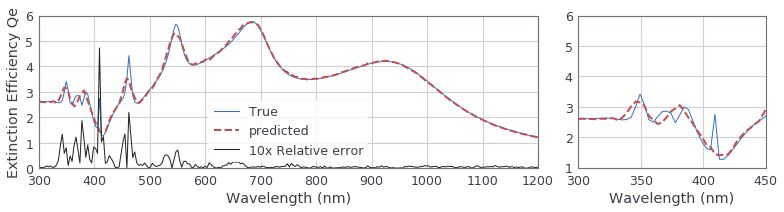

In [4]:
from matplotlib import gridspec
import snlay as snlay
#here we test edge cases where failure happens
#size = np.array([70, 60, 50, 40, 30, 20, 10, 10])
#size = np.array([70, 70, 70, 70, 70, 70, 70, 70])
#size = np.array([30, 30, 30, 30, 30, 30, 30, 30])

#size = np.array([65, 65, 65, 65, 55, 65, 35, 65])
#size = np.array([65, 35, 45, 35, 45, 35, 45, 35])

size = np.random.randint(30, 71, 8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
spec_ac = snlay.calc_spectrum(size, mats, lams)

print(size)


size = (size - 50.0)/20.0



spec = model.predict(np.expand_dims(size, axis = 0))

spec = np.ravel(spec)


fig1 = plt.figure(figsize=(11,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 3]) 

ax = plt.subplot(gs[0])
#ax = fig1.add_subplot(1,2,1)
#ax.set_title('silica coated gold')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Extinction Efficiency Qe')
ax.set_ylim((0, 6))
ax.set_xlim((300, 1200))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'k', linewidth=1, label='10x Relative error')
ax.legend(loc='best')

ax2 = plt.subplot(gs[1])
#fig2 = plt.figure(figsize=(3,3))
#ax2 = fig1.add_subplot(1,2,2)
#ax.set_title('silica coated gold')
ax2.set_xlabel('Wavelength (nm)')
#ax.set_ylabel('Extinction Efficiency Qe')
#ax2.set_ylim((2, 6))
ax2.set_xlim((300, 450))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
#plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'b', linewidth=1, label='10x Relative error')
#ax.legend(loc='best')



plt.tight_layout()
plt.savefig('grid_figure.pdf')






In [5]:
size.shape

(8,)

In [6]:
# loop for hundred runs 
import snlay as snlay
import time

mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
#spec_ac = snlay.calc_spectrum(size, mats, lams)

reps = 100


start = time.time()
for ind in np.arange(reps):
    size = np.random.randint(30, 71, 8)
    #size = np.random.randint(30, 71, (1,8))
    #spec_ac = snlay.calc_spectrum(size, mats, lams)
    size = (size - 50.0)/20.0
    size = np.expand_dims(size, axis=0)
    spec = model.predict(size)
    #data_iter = mx.io.NDArrayIter(size, None, 1)
    #result = mod.predict(size)
    #result = result.asnumpy()

    
end = time.time()
print(1000*(end - start)/reps)   
    


result



1.829695701599121


NameError: name 'result' is not defined

### Inverse scattering 

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Add, AveragePooling1D, MaxPooling1D, Concatenate



# a = Input(shape=(1,))
# first = Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
#               name='dummy', use_bias=False)(a)
# last = model(first)
# #last = Dense(256, kernel_initializer='normal')(first)
# #last = Flatten()(first)

# model_d = Model(inputs=a, outputs=last)
# model_d.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K], context=['gpu(0)'])

model_d = Sequential()
model_d.add(Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False))

for layer in model.layers[1:]:
    model_d.add(layer)

# for layer in model_d.layers[1:]:
#     layer.trainable = False

# for ind in range(1,len(model_d.layers)):
#     model_d.layers[ind].set_weights(model.layers[ind-1].get_weights())

model_d.compile(loss=naive_percent_loss, optimizer='adam')    
    
    
model_d.summary()


for layer in model.layers[1:]:
    print(layer)






# # # let us create a target spectrum first
# import snlay as snlay
# #size = np.array([60, 65, 65, 65, 35, 35, 35, 35])
# size = np.random.randint(30,70,8)
# mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
# target = snlay.calc_spectrum(size, mats, lams)

# print(size)

# # #do the training here
# xd_t = np.ones((1,1))
# yd_t = target.reshape(1,250)





# history = model_d.fit(xd_t, yd_t,
#                     batch_size=1,
#                     epochs=5000, 
#                     verbose=0)

# # #here is the final result
# size_out = model_d.get_layer('dummy')
# wts = size_out.get_weights()
# wts = np.array(wts).ravel()
# size_res= 0.5*wts*(size_max - size_min) + size_av
# size_res_rounded = np.round(size_res)

# spec_zer = model_d.predict(xd_t).ravel()
# achieved = snlay.calc_spectrum(size_res_rounded, mats, lams)


# fig1 = plt.figure(figsize=(22,5))
# ax = fig1.add_subplot(1,1,1)
# #plt.plot(lams, spec_zer, label='new model')
# plt.plot(lams, target, linewidth=2, label='target')
# plt.plot(lams, achieved, '--', linewidth=3, label='achieved')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# print(size_res_rounded)


In [ ]:
from keras.models import Model
from keras.layers import Input, Add, AveragePooling1D, MaxPooling1D, Concatenate

a = Input(shape=(8,))
first = Dense(256, kernel_initializer='normal')(a)
#first = Dense(128, kernel_initializer='normal')(first)
#first = BatchNormalization()(first)
first= Activation('relu')(first)

first = Reshape((256,1))(first)
#first = UpSampling1D(size = 2)(first)
first = Conv1D(filters=32, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal', activation='relu')(first)
#first = UpSampling1D(size = 2)(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)



# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)

# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)





first = Reshape((32,256))(first)
first = MaxPooling1D(pool_size=32, strides=None, padding='same')(first)
last = Flatten()(first)

model = Model(inputs=a, outputs=last)
model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K], context=['gpu(0)'])

#model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))


plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model.png')
#plot_model(model, to_file='model.png', )

x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_test, y_test))






### Model shipment

In [ ]:

    
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')



In [ ]:

from keras.models import Model
from keras.layers import Input, Add, Lambda, Dense
import numpy as np


def dropper(x):
    ms = 4
    #print(x.shape)
    
   
    
    return x**2
# msk = np.array([1,1,1,1,0,0,0,0])


a = Input(shape=(1,))
b = Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False)(a)
b = Lambda(dropper)(b)
b = Dense(256)(b)
# #b = Lambda()
# a = Lambda(dropper)(a)
# 

model = Model(inputs=a, outputs=b)

# model = Sequential()
# model.add(Dense(256, input_dim=8))
# #model.add(Lambda(lambda x: x**2))
# model.add(Lambda(dropper))
# model.add(Dense(256))



model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#model.summary()

In [ ]:
2 +2 

In [ ]:
import matplotlib.pyplot as plt